In [4]:
%pip install torch torchvision 

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached torch-2.8.0-cp312-cp312-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.8/241.3 MB 2.1 MB/s eta 0:01:55
   ---------------------------------------- 1.3/241.3 MB 2.1 MB/s eta 0:01:55
   ---------------------------------------- 1.6/241.3 MB 2.1 MB/s eta 0:01:55
   ---------------------------------------- 2.1/241.3 MB 2.0 MB/s eta 0:02:01
   ---------------------------------------- 2.4/241.3 MB 2.0 MB/s eta 0:02:02
 

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Users\\Sayantan\\Desktop\\Marketsage\\.venv\\Lib\\site-packages\\sympy\\functions\\elementary\\integers.py'
Check the permissions.



In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import datetime as dt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
train_start = "2005-01-01"
train_end   = "2025-01-01"
test_start  = "2025-01-01"
test_end    = pd.Timestamp.today()
# === Stock Data ===
symbol = "ITC.NS"
df = yf.download(symbol, start=train_start, end=pd.Timestamp.today(), auto_adjust=True)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df = df[['Open','High','Low','Close','Volume']]

# === Stock Info ===
ticker = yf.Ticker(symbol)
info = ticker.info
print("Company:", info.get("longName"))
print("Sector:", info.get("sector"))
print("Industry:", info.get("industry"))

# === Sector mapping ===
sector_map = {
    "Financial Services": "^NSEBANK",
    "Banks": "^NSEBANK",
    "Technology": "^CNXIT",
    "Energy": "^CNXENERGY",
    "Consumer Defensive": "^CNXFMCG",
    "Healthcare": "^CNXPHARMA",
    "Pharmaceuticals": "^CNXPHARMA",
    "Consumer Cyclical": "^CNXAUTO",
    "Basic Materials": "^CNXMETAL",
    "Real Estate": "^CNXREALTY"
}

sector_symbol = sector_map.get(info.get("sector"), "^NSEI")  # fallback Nifty 50
print("Using sector index:", sector_symbol)

# === Sector Data ===
sector_df = yf.download(sector_symbol, start=train_start, end=pd.Timestamp.today(), auto_adjust=True)
if isinstance(sector_df.columns, pd.MultiIndex):
    sector_df.columns = sector_df.columns.get_level_values(0)

sector_df = sector_df[['Close']].rename(columns={'Close':'Sector_Close'})

# Align dates + merge
df = df.join(sector_df, how="inner")

# === Indicators for stock ===
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# === Indicators for sector ===
df['Sector_EMA20'] = df['Sector_Close'].ewm(span=20, adjust=False).mean()
df['Sector_EMA50'] = df['Sector_Close'].ewm(span=50, adjust=False).mean()

sector_delta = df['Sector_Close'].diff()
sector_gain = (sector_delta.where(sector_delta > 0, 0)).rolling(14).mean()
sector_loss = (-sector_delta.where(sector_delta < 0, 0)).rolling(14).mean()
sector_rs = sector_gain / sector_loss
df['Sector_RSI'] = 100 - (100 / (1 + sector_rs))

sector_ema12 = df['Sector_Close'].ewm(span=12, adjust=False).mean()
sector_ema26 = df['Sector_Close'].ewm(span=26, adjust=False).mean()
df['Sector_MACD'] = sector_ema12 - sector_ema26
df['Sector_MACD_Signal'] = df['Sector_MACD'].ewm(span=9, adjust=False).mean()

# Clean
df.dropna(inplace=True)
print(df.shape)
df.tail()


[*********************100%***********************]  1 of 1 completed


Company: ITC Limited
Sector: Consumer Defensive
Industry: Tobacco
Using sector index: ^CNXFMCG


[*********************100%***********************]  1 of 1 completed

(3557, 16)


Price,Open,High,Low,Close,Volume,Sector_Close,EMA20,EMA50,RSI,MACD,MACD_Signal,Sector_EMA20,Sector_EMA50,Sector_RSI,Sector_MACD,Sector_MACD_Signal
Date,,,,,,,,,,,,,,,,
2025-08-13,417.200012,417.500000,413.600006,414.100006,10874910,55010.148438,414.794482,416.060937,58.283415,-0.578043,-0.987116,55386.509223,55428.531468,49.112133,-102.850466,-29.891436
2025-08-14,414.250000,415.049988,411.000000,411.450012,9580361,54656.300781,414.475961,415.880116,53.775357,-0.781161,-0.945925,55316.965562,55398.247911,50.928592,-147.259152,-53.364979
2025-08-18,413.000000,413.700012,404.850006,406.299988,30950814,55304.250000,413.697297,415.504425,44.339616,-1.342224,-1.025185,55315.754556,55394.561719,56.201570,-128.685858,-68.429155
2025-08-19,406.350006,409.399994,404.500000,409.100006,16681331,55886.648438,413.259460,415.253271,50.980381,-1.543145,-1.128777,55370.125402,55413.859237,59.895042,-66.208492,-67.985022
2025-08-20,409.100006,410.250000,405.450012,406.049988,18085865,56664.050781,412.572843,414.892358,47.807616,-1.926282,-1.288278,55493.356391,55462.886357,64.472722,45.510526,-45.285913


In [7]:
features = ['Close','Open', 'High', 'Low', 'Volume', 'Sector_Close', 'EMA20',
       'EMA50', 'RSI', 'MACD', 'MACD_Signal', 'Sector_EMA20', 'Sector_EMA50',
       'Sector_RSI', 'Sector_MACD', 'Sector_MACD_Signal']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i,0])  # Close
X, y = np.array(X), np.array(y)

# Split into train/test
split_idx = int(0.9*len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (3147, 60, 16) X_test: (350, 60, 16)


In [30]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# # Features
# features = ['Close','Open', 'High', 'Low', 'Volume', 'Sector_Close',
#             'EMA20', 'EMA50', 'RSI', 'MACD', 'MACD_Signal',
#             'Sector_EMA20', 'Sector_EMA50', 'Sector_RSI',
#             'Sector_MACD', 'Sector_MACD_Signal']

# # Scale
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(df[features])

# # Prepare sequences
# lookback = 60
# X_rf, y_rf = [], []
# for i in range(lookback, len(scaled)):
#     X_rf.append(scaled[i-lookback:i])  # shape (lookback, features)
#     y_rf.append(scaled[i, 0])          # Close

# X_rf, y_rf = np.array(X_rf[:1000]), np.array(y_rf[:1000])
# print("X shape before flattening:", X_rf.shape)

# # Flatten time dimension for RandomForest
# n_samples, n_steps, n_features = X_rf.shape
# X_flat = X_rf.reshape(n_samples, n_steps * n_features)
# print("X shape after flattening:", X_flat.shape)

# # Train/test split
# split_idx = int(0.75*len(X_flat))
# X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
# y_train, y_test = y_rf[:split_idx], y_rf[split_idx:]

# # Train Random Forest
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Feature importances
# importances = rf.feature_importances_

# # Map importances back to feature names (average over lookback window)
# importances_per_feature = np.mean(importances.reshape(lookback, n_features), axis=0)

# # Plot
# plt.figure(figsize=(12,6))
# plt.bar(features, importances_per_feature)
# plt.xticks(rotation=45)
# plt.ylabel("Importance")
# plt.title("Random Forest Feature Importance for predicting Close")
# plt.show()


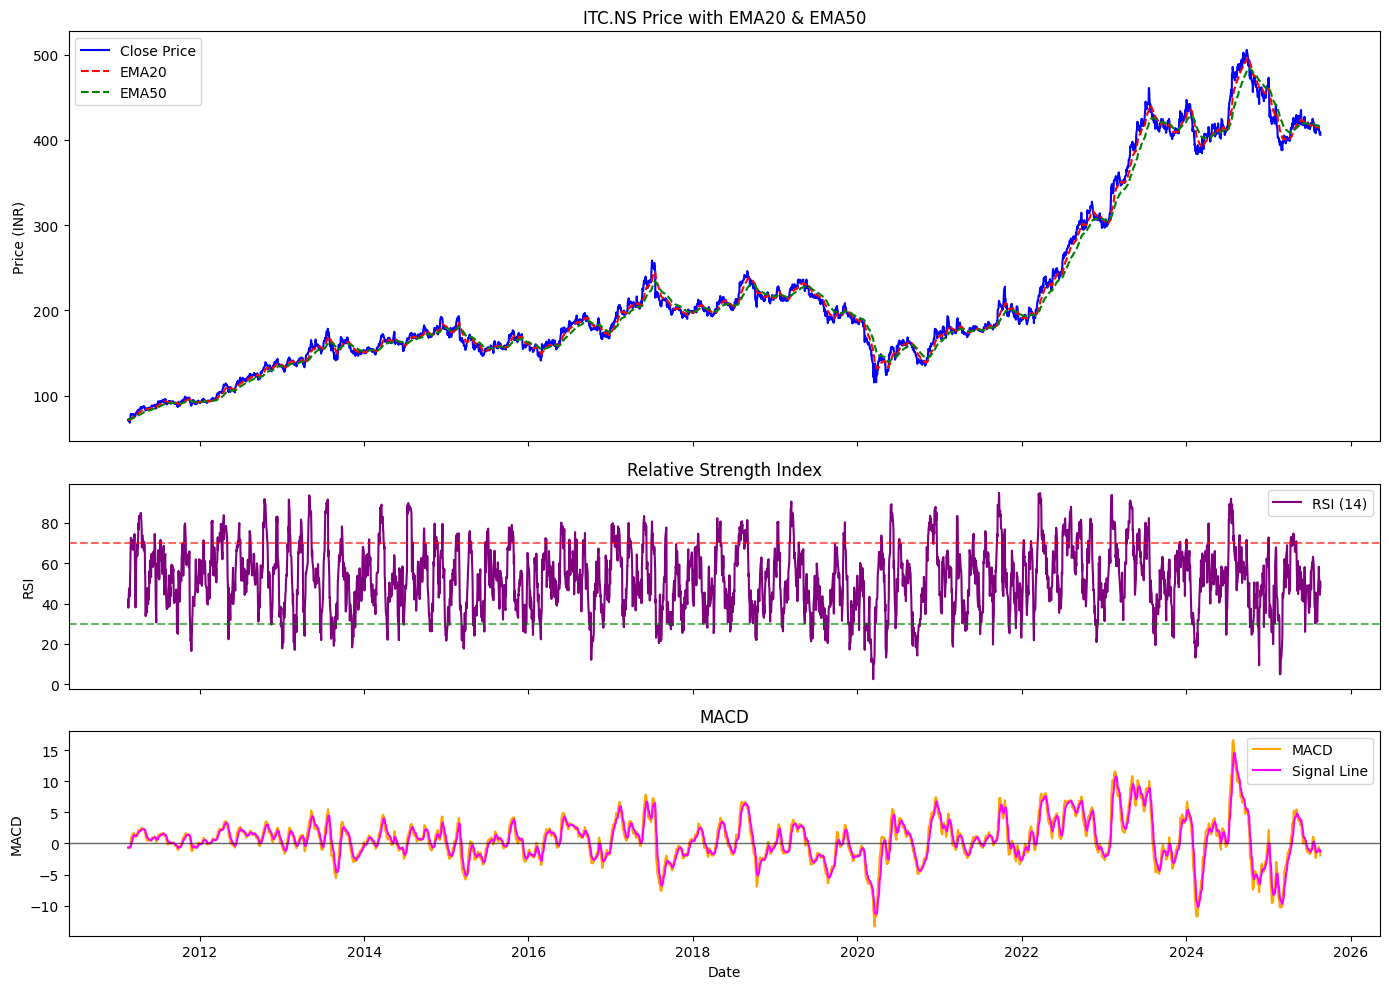

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios':[2,1,1]})

# --- Price with EMA ---
ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
ax1.plot(df.index, df['EMA20'], label='EMA20', color='red', linestyle='--')
ax1.plot(df.index, df['EMA50'], label='EMA50', color='green', linestyle='--')
ax1.set_title(f"{symbol} Price with EMA20 & EMA50")
ax1.set_ylabel("Price (INR)")
ax1.legend()

# --- RSI ---
ax2.plot(df.index, df['RSI'], label='RSI (14)', color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.6)   # Overbought
ax2.axhline(30, color='green', linestyle='--', alpha=0.6) # Oversold
ax2.set_ylabel("RSI")
ax2.set_title("Relative Strength Index")
ax2.legend()

# --- MACD ---
ax3.plot(df.index, df['MACD'], label='MACD', color='orange')
ax3.plot(df.index, df['MACD_Signal'], label='Signal Line', color='magenta')
ax3.axhline(0, color='black', linewidth=1, alpha=0.6)
ax3.set_ylabel("MACD")
ax3.set_title("MACD")
ax3.legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [12]:
train_df = df.loc[train_start:train_end]
test_df  = df.loc[test_start:test_end]

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)
df.shape

Train size: (3400, 16)
Test size: (157, 16)


(3557, 16)

In [15]:
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.mixed_precision import set_global_policy

# Enable mixed precision training for faster GPU computation
set_global_policy('mixed_float16')

# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available for training")
    except RuntimeError as e:
        print(e)
# Split training data for validation
val_size = int(len(X_train) * 0.1)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_final = X_train[:-val_size]
y_train_final = y_train[:-val_size]

# Convert data to tensors for faster GPU processing
X_train_tensor = tf.convert_to_tensor(X_train_final, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_final, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

# Create TensorFlow datasets with optimized batch size
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))\
    .batch(batch_size)\
    .prefetch(tf.data.AUTOTUNE)  # Enable prefetching for better GPU utilization

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))\
    .batch(batch_size)\
    .prefetch(tf.data.AUTOTUNE)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# LSTM model with GPU optimizations
lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True, dtype='float16'),  # Use float16 for faster computation
    Dropout(0.2),
    LSTM(128, return_sequences=True, dtype='float16'),
    Dropout(0.2),
    LSTM(64, dtype='float16'),
    Dropout(0.2),
    Dense(1)
])

# Compile with mixed precision optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

lstm.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train with optimized parameters for GPU
history = lstm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 820ms/step - loss: 2.1572 - mae: 1.1746 - val_loss: 0.2319 - val_mae: 0.4718 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 820ms/step - loss: 2.1572 - mae: 1.1746 - val_loss: 0.2319 - val_mae: 0.4718 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 0.0465 - mae: 0.1822 - val_loss: 0.1252 - val_mae: 0.3404 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 0.0465 - mae: 0.1822 - val_loss: 0.1252 - val_mae: 0.3404 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 894ms/step - loss: 0.0490 - mae: 0.1810 - val_loss: 0.2106 - val_mae: 0.4486 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 894ms/step - loss: 0.0490 - mae: 0.1810 - val_loss: 0.2106 - val_mae: 0.4486 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 926ms/step - loss: 0.0358 - mae: 0.1499 - val_loss: 0.2289 - val_mae: 0.4686 - learning_rate: 0.0010

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
import numpy as np
import torch.cuda.amp as amp

# ===== Positional Encoding =====
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]

# ===== Transformer Model =====
class TransformerModel(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int = 32, num_heads: int = 4,
                 num_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.fc_out(x[:, -1, :])

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                criterion, optimizer, scaler, epochs: int = 50, patience: int = 5, device=None):
    best_val_loss = float("inf")
    wait = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        # Training loop with mixed precision
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Mixed precision training
            with amp.autocast():
                output = model(X_batch)
                loss = criterion(output, y_batch)

            # Scale loss and backprop
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            total_loss += loss.item() * X_batch.size(0)
            num_batches += 1

            # Optional: Clear cache periodically
            if num_batches % 10 == 0:
                torch.cuda.empty_cache()

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Validation with mixed precision
        model.eval()
        val_loss = 0
        with torch.no_grad(), amp.autocast():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model(X_val)
                val_loss += criterion(val_pred, y_val).item() * X_val.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚀")
                break

        # Clear cache at end of epoch
        torch.cuda.empty_cache()

    model.load_state_dict(best_weights)
    return model

In [17]:
import torch.cuda.amp as amp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable CUDA optimization
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TensorFloat-32

# Configure for optimal memory usage
batch_size = 256  # Increased for better GPU utilization
torch.cuda.empty_cache()  # Clear GPU memory

# ===== Prepare Data =====
# Convert numpy arrays to torch tensors and move to GPU
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Train/Val split (from train set)
val_split = int(0.9 * len(X_train_torch))
train_data = TensorDataset(X_train_torch[:val_split], y_train_torch[:val_split])
val_data = TensorDataset(X_train_torch[val_split:], y_train_torch[val_split:])

# Create data loaders with optimized settings for 1660 Super
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,  # Increased for better CPU utilization
    persistent_workers=True  # Keep workers alive between batches
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size*2,  # Larger batches for validation
    pin_memory=True,
    num_workers=4,
    persistent_workers=True
)

# ===== Train Transformer =====
trans = TransformerModel(
    feature_size=X_train.shape[2],
    hidden_dim=128,  # Increased for better model capacity
    num_heads=8,     # Increased number of attention heads
    num_layers=3,    # Added one more layer
    dropout=0.1
).to(device)

# Use gradient clipping to prevent exploding gradients
torch.nn.utils.clip_grad_norm_(trans.parameters(), max_norm=1.0)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(  # Using AdamW instead of Adam
    trans.parameters(),
    lr=2e-4,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)
scaler = amp.GradScaler()  # For mixed precision training

# Training loop with optimizations
trans = train_model(trans, train_loader, val_loader, criterion, optimizer, scaler,
                   epochs=50, patience=10, device=device)

# Function definitions
def inverse_transform(preds, scaler, n_features, target_col=0):
    """
    Inverse transform for predictions using the fitted scaler.
    preds: shape (N,1)
    scaler: fitted MinMaxScaler
    n_features: total features used in training
    target_col: column index of target in 'features' list (default=0 -> 'Close')
    """
    dummy = np.zeros((len(preds), n_features))
    dummy[:, target_col] = preds.flatten()
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_col]

@torch.cuda.amp.autocast()  # Enable automatic mixed precision
def get_predictions(model, X_torch, scaler, y_true=None, recalibrate=False):
    model.eval()
    with torch.no_grad(), amp.autocast():
        preds = model(X_torch.to(device)).cpu().numpy()
    preds_rescaled = inverse_transform(preds, scaler, len(features))

    if recalibrate and y_true is not None:
        if isinstance(y_true, torch.Tensor):
            y_rescaled = inverse_transform(y_true.cpu().numpy(), scaler, len(features), target_col=0)
        else:
            y_rescaled = inverse_transform(y_true, scaler, len(features), target_col=0)

        recal = LinearRegression()
        recal.fit(preds_rescaled.reshape(-1,1), y_rescaled.reshape(-1,1))
        preds_rescaled = recal.predict(preds_rescaled.reshape(-1,1)).flatten()

    return preds_rescaled

C:\Users\Sayantan\AppData\Local\Temp\ipykernel_14508\228036627.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # For mixed precision training
c:\Users\Sayantan\Desktop\Marketsage\.venv\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\Sayantan\Desktop\Marketsage\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Sayantan\AppData\Local\Temp\ipykernel_14508\2403773745.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
c:\Users\Sayantan\Desktop\Marketsage\.venv\Lib\site-packages\torch\amp\autocast_mode.

Epoch 1: Train Loss = 0.4107, Val Loss = 0.0120
Epoch 2: Train Loss = 0.0636, Val Loss = 0.2272
Epoch 2: Train Loss = 0.0636, Val Loss = 0.2272
Epoch 3: Train Loss = 0.0220, Val Loss = 0.2648
Epoch 3: Train Loss = 0.0220, Val Loss = 0.2648
Epoch 4: Train Loss = 0.0153, Val Loss = 0.1221
Epoch 4: Train Loss = 0.0153, Val Loss = 0.1221
Epoch 5: Train Loss = 0.0096, Val Loss = 0.1038
Epoch 5: Train Loss = 0.0096, Val Loss = 0.1038
Epoch 6: Train Loss = 0.0076, Val Loss = 0.0902
Epoch 6: Train Loss = 0.0076, Val Loss = 0.0902
Epoch 7: Train Loss = 0.0053, Val Loss = 0.0485
Epoch 7: Train Loss = 0.0053, Val Loss = 0.0485
Epoch 8: Train Loss = 0.0044, Val Loss = 0.0229
Epoch 8: Train Loss = 0.0044, Val Loss = 0.0229
Epoch 9: Train Loss = 0.0042, Val Loss = 0.0234
Epoch 9: Train Loss = 0.0042, Val Loss = 0.0234
Epoch 10: Train Loss = 0.0041, Val Loss = 0.0219
Epoch 10: Train Loss = 0.0041, Val Loss = 0.0219
Epoch 11: Train Loss = 0.0036, Val Loss = 0.0213
Early stopping 🚀
Epoch 11: Train Loss

C:\Users\Sayantan\AppData\Local\Temp\ipykernel_14508\228036627.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()  # Enable automatic mixed precision


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ===== Evaluate Hybrid with Different Weights =====
weights = np.linspace(0, 1, 41)  # 0.0, 0.05, ..., 1.0
results = []

for w in weights:
    hybrid_preds = w * lstm_preds_rescaled + (1-w) * trans_preds_rescaled

    mse = mean_squared_error(actual_prices, hybrid_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, hybrid_preds)
    r2 = r2_score(actual_prices, hybrid_preds)

    results.append((w, mse, rmse, mae, r2))

# Convert to nice array
results = np.array(results, dtype=object)

# Find best weight by RMSE
best_idx = np.argmin(results[:,2])  # index of lowest RMSE
best_weight, best_mse, best_rmse, best_mae, best_r2 = results[best_idx]

print("===== Hybrid Model Evaluation =====")
print("Best Hybrid Weight:", best_weight)
print(f"MSE: {best_mse:.4f}, RMSE: {best_rmse:.4f}, MAE: {best_mae:.4f}, R²: {best_r2:.4f}")

# Optional: Show all results
import pandas as pd
metrics_df = pd.DataFrame(results, columns=["Weight", "MSE", "RMSE", "MAE", "R2"])
display(metrics_df)

NameError: name 'lstm_preds_rescaled' is not defined

In [90]:
trans_preds_rescaled = get_predictions(trans, X_test_torch, scaler, y_test, recalibrate=True)
lstm_preds_rescaled = inverse_transform(lstm.predict(X_test), scaler, len(features))

# ===== Hybrid Ensemble =====
hybrid_weight = 0.075
hybrid_preds = hybrid_weight * lstm_preds_rescaled + (1-hybrid_weight) * trans_preds_rescaled

# ===== Actual Prices =====
actual_prices = inverse_transform(y_test.reshape(-1,1), scaler, len(features))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


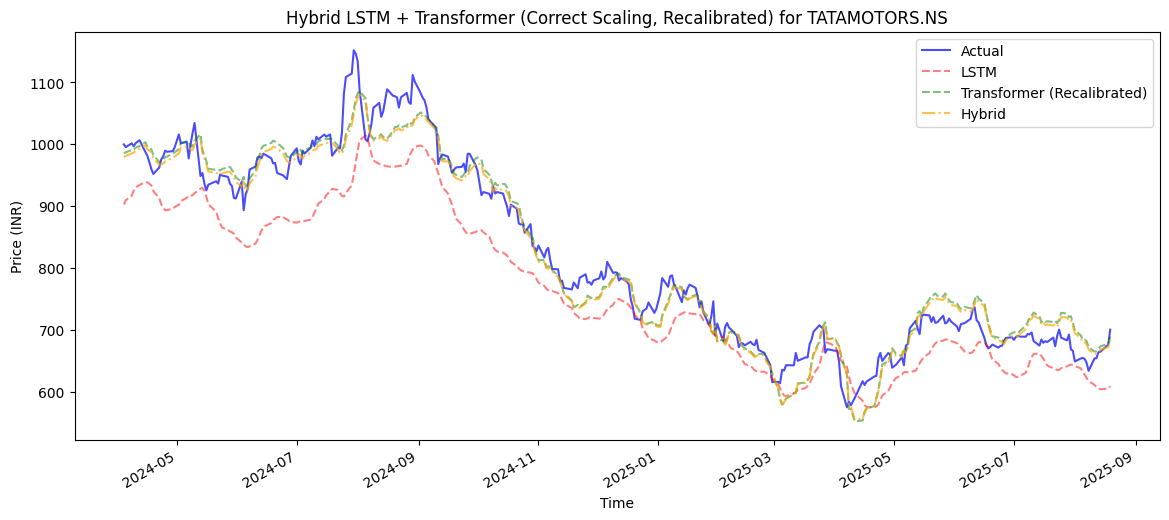

In [91]:
plt.figure(figsize=(14,6))

# Use dates from your test set index
dates = df.index[-len(actual_prices):]

plt.plot(dates, actual_prices, label="Actual", color="blue", alpha=0.7)
plt.plot(dates, lstm_preds_rescaled, label="LSTM", linestyle="--", color="red", alpha=0.5)
plt.plot(dates, trans_preds_rescaled, label="Transformer (Recalibrated)", linestyle="--", color="green", alpha=0.5)
plt.plot(dates, hybrid_preds, label="Hybrid", linestyle="-.", color="orange", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.title(f"Hybrid LSTM + Transformer (Correct Scaling, Recalibrated) for {symbol}", alpha=1)
plt.legend()

# Format x-axis ticks as dates
plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()

plt.show()
